In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K

Using TensorFlow backend.


In [5]:
# load the data
airplane = np.load('Data/airplane.npy')
square = np.load('Data/square.npy')

airplane = airplane[:1000]
square = square[:1000]

print(airplane.shape)
print(square.shape)


(1000, 784)
(1000, 784)


In [6]:
airplane = np.c_[airplane, np.zeros(len(airplane))]
square = np.c_[square, np.ones(len(square))]

In [7]:
def plot_samples(input_array, rows=4, cols=5, title=''):
    '''
    Function to plot 28x28 pixel drawings that are stored in a numpy array.
    Specify how many rows and cols of pictures to display (default 4x5).  
    If the array contains less images than subplots selected, surplus subplots remain empty.
    '''
    
    fig, ax = plt.subplots(figsize=(cols,rows))
    ax.axis('off')
    plt.title(title)

    for i in list(range(0, min(len(input_array),(rows*cols)) )):      
        a = fig.add_subplot(rows,cols,i+1)
        imgplot = plt.imshow(input_array[i,:784].reshape((28,28)), cmap='gray_r', interpolation='nearest')
        plt.xticks([])
        plt.yticks([])

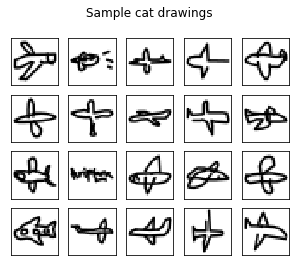

In [8]:
plot_samples(airplane, title='Sample cat drawings\n')

In [43]:
# merge the arrays, and split the features (X) and labels (y). Convert to float32 to save some memory.
X = np.concatenate((airplane[:10000,:-1], square[:10000,:-1]), axis=0).astype('float32') # all columns but the last
y = np.concatenate((airplane[:10000,-1], square[:10000,-1]), axis=0).astype('float32') # the last column

# train/test split (divide by 255 to obtain normalized values between 0 and 1)
# Use a 50:50 split, training the models on 10'000 samples and thus have plenty of samples to spare for testing.
X_train, X_test, y_train, y_test = train_test_split(X/255.,y,test_size=0.5,random_state=0)

In [44]:
# one hot encode outputs
y_train_cnn = np_utils.to_categorical(y_train)
y_test_cnn = np_utils.to_categorical(y_test)
num_classes = y_test_cnn.shape[1]

# reshape to be [samples][pixels][width][height]
X_train_cnn = X_train.reshape(X_train.shape[0], 1, 28, 28).astype('float32')
X_test_cnn = X_test.reshape(X_test.shape[0], 1, 28, 28).astype('float32')
s = X_train_cnn.shape
print (s, num_classes)

(1000, 1, 28, 28) 2


In [48]:
# define the CNN model
def cnn_model():
    # create model
    model = Sequential()
    
    model.add(Conv2D(30, (5, 5), input_shape=(1, 28, 28), data_format='channels_first',activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(15, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Dropout(0.2))
    model.add(Flatten())
    
    model.add(Dense(128, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [49]:
X_train_cnn.shape

(1000, 1, 28, 28)

In [50]:
%%time

# build the model
model = cnn_model()
# Fit the model
history = model.fit(X_train_cnn, y_train_cnn, validation_data=(X_test_cnn, y_test_cnn), epochs=30, batch_size=50)
# Final evaluation of the model
scores = model.evaluate(X_test_cnn, y_test_cnn, verbose=0)
print('Final CNN accuracy: ', scores[1]*100, "%")

# Save weights
model.save_weights('quickdraw_neuralnet.h5')
model.save('quickdraw.model')
print("Model is saved")

W0916 17:00:49.695672 139780301375296 deprecation_wrapper.py:119] From /home/academy-1/anaconda3/envs/myenv/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:190: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0916 17:00:49.697053 139780301375296 deprecation_wrapper.py:119] From /home/academy-1/anaconda3/envs/myenv/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:197: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0916 17:00:51.169546 139780301375296 deprecation_wrapper.py:119] From /home/academy-1/anaconda3/envs/myenv/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4267: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0916 17:00:51.212276 139780301375296 deprecation.py:506] From /home/academy-1/anaconda3/envs/myenv/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3733: calling dropout (from tensorflow.py

Train on 1000 samples, validate on 1000 samples
Epoch 1/30
1000/1000 [==============================] - 5s 5ms/step - loss: 0.2707 - acc: 0.9280 - val_loss: 0.0993 - val_acc: 0.9700
Epoch 2/30
1000/1000 [==============================] - 1s 841us/step - loss: 0.1277 - acc: 0.9630 - val_loss: 0.0733 - val_acc: 0.9790
Epoch 3/30
1000/1000 [==============================] - 1s 853us/step - loss: 0.0969 - acc: 0.9680 - val_loss: 0.0777 - val_acc: 0.9720
Epoch 4/30
1000/1000 [==============================] - 1s 860us/step - loss: 0.0888 - acc: 0.9670 - val_loss: 0.0673 - val_acc: 0.9790
Epoch 5/30
1000/1000 [==============================] - 1s 841us/step - loss: 0.0679 - acc: 0.9780 - val_loss: 0.0638 - val_acc: 0.9790
Epoch 6/30
1000/1000 [==============================] - 1s 890us/step - loss: 0.0672 - acc: 0.9750 - val_loss: 0.0675 - val_acc: 0.9810
Epoch 7/30
1000/1000 [==============================] - 1s 873us/step - loss: 0.0612 - acc: 0.9750 - val_loss: 0.0625 - val_acc: 0.9780
Ep